In [ ]:
#Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [57]:
#setting seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
#loading the dat
data_dir = r"D:\Projects\DL_gtzan\data\preprocessed_data"

X_train, y_train = joblib.load(os.path.join(data_dir, "train_data_scaled.pkl"))
X_val, y_val     = joblib.load(os.path.join(data_dir, "val_data_scaled.pkl"))
X_test, y_test   = joblib.load(os.path.join(data_dir, "test_data_scaled.pkl"))


In [ ]:
#Dataset loader class

class genreDataloader(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_loader = DataLoader(genreDataloader(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(genreDataloader(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(genreDataloader(X_test, y_test), batch_size=batch_size, shuffle=False)


In [ ]:
#intializing the Deeper MLP model
class DeepGenreMLP(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
#Training loop
def train_loop(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (pred.argmax(1) == yb).sum().item()

    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            correct += (pred.argmax(1) == yb).sum().item()
    return correct / len(dataloader.dataset)


In [ ]:
#Training the model
input_dim = X_train.shape[1]
model = DeepGenreMLP(input_dim=input_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

epochs = 100
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_loop(model, train_loader, loss_fn, optimizer, device)
    val_acc = evaluate(model, val_loader, device)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)


Epoch 1/100 | Train Acc: 0.4466 | Val Acc: 0.6582
Epoch 2/100 | Train Acc: 0.6557 | Val Acc: 0.7417
Epoch 3/100 | Train Acc: 0.7200 | Val Acc: 0.7730
Epoch 4/100 | Train Acc: 0.7640 | Val Acc: 0.7977
Epoch 5/100 | Train Acc: 0.7991 | Val Acc: 0.8244
Epoch 6/100 | Train Acc: 0.8101 | Val Acc: 0.8198
Epoch 7/100 | Train Acc: 0.8277 | Val Acc: 0.8538
Epoch 8/100 | Train Acc: 0.8423 | Val Acc: 0.8498
Epoch 9/100 | Train Acc: 0.8679 | Val Acc: 0.8652
Epoch 10/100 | Train Acc: 0.8692 | Val Acc: 0.8732
Epoch 11/100 | Train Acc: 0.8856 | Val Acc: 0.8645
Epoch 12/100 | Train Acc: 0.8857 | Val Acc: 0.8712
Epoch 13/100 | Train Acc: 0.8890 | Val Acc: 0.8765
Epoch 14/100 | Train Acc: 0.9019 | Val Acc: 0.8798
Epoch 15/100 | Train Acc: 0.8975 | Val Acc: 0.8805
Epoch 16/100 | Train Acc: 0.9076 | Val Acc: 0.8772
Epoch 17/100 | Train Acc: 0.9112 | Val Acc: 0.8945
Epoch 18/100 | Train Acc: 0.9118 | Val Acc: 0.8899
Epoch 19/100 | Train Acc: 0.9175 | Val Acc: 0.8905
Epoch 20/100 | Train Acc: 0.9274 | Val A

In [ ]:
#Evaluating the model


def evaluate_model_results(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = yb.numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()



🎯 Accuracy: 0.9253

📋 Classification Report:
              precision    recall  f1-score   support

       blues     0.9467    0.9467    0.9467       150
   classical     0.9404    0.9467    0.9435       150
     country     0.9184    0.9060    0.9122       149
       disco     0.9085    0.9267    0.9175       150
      hiphop     0.9653    0.9267    0.9456       150
        jazz     0.8981    0.9400    0.9186       150
       metal     0.9262    0.9200    0.9231       150
         pop     0.9346    0.9533    0.9439       150
      reggae     0.9463    0.9400    0.9431       150
        rock     0.8699    0.8467    0.8581       150

    accuracy                         0.9253      1499
   macro avg     0.9254    0.9253    0.9252      1499
weighted avg     0.9254    0.9253    0.9252      1499



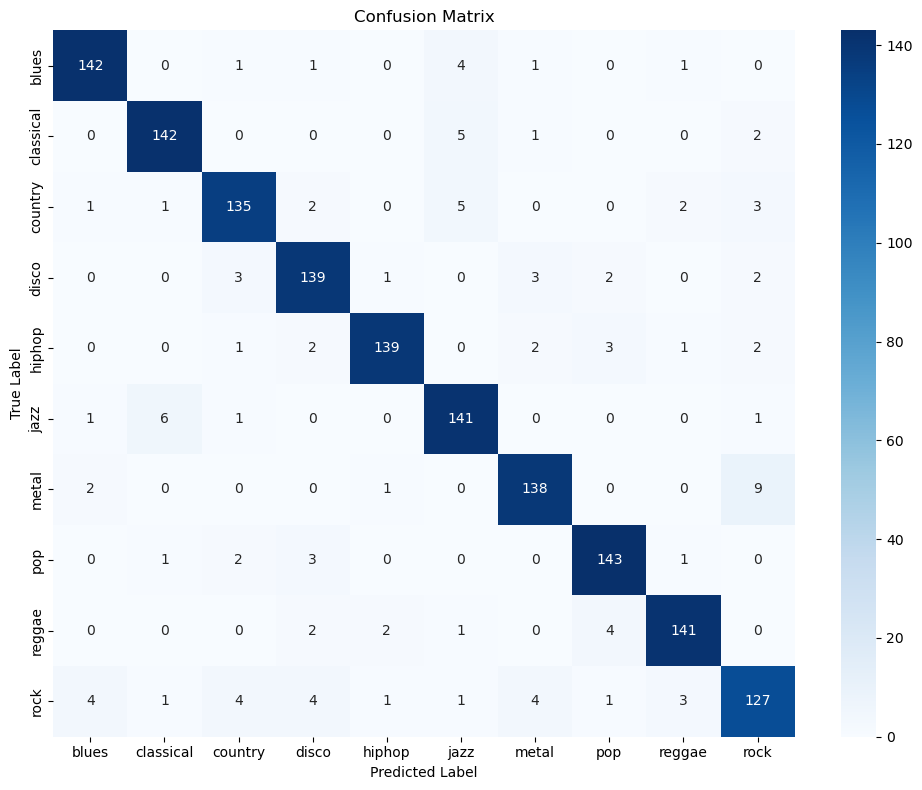

In [64]:
# Load label encoder used during preprocessing
import joblib
label_encoder = joblib.load(r"D:\Projects\music_genre_classification\music_genre_classification\data\Processed_data\label_encoder.pkl")
class_names = list(label_encoder.classes_)

# Or manually define if not saved
# class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Run final test evaluation
evaluate_model_results(model, test_loader, class_names, device)


In [71]:
def evaluate_metrics(model, dataloader, device, class_names):
    """
    Runs the model on dataloader, prints classification report,
    and returns the confusion matrix.
    
    model:         trained torch.nn.Module
    dataloader:    DataLoader for the split you want to evaluate
    device:        torch.device('cuda' or 'cpu')
    class_names:   list of label names in order
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("=== Classification Report ===\n", report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Matplotlib.
    cm:           numpy array of shape (n_classes, n_classes)
    class_names:  list of label strings
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    history: dict with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
             each mapping to a list of length num_epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    plt.figure()
    plt.plot(epochs, history['train_loss'])
    plt.plot(epochs, history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Loss')
    plt.show()

    # Accuracy curves
    plt.figure()
    plt.plot(epochs, history['train_acc'])
    plt.plot(epochs, history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Accuracy')
    plt.show()


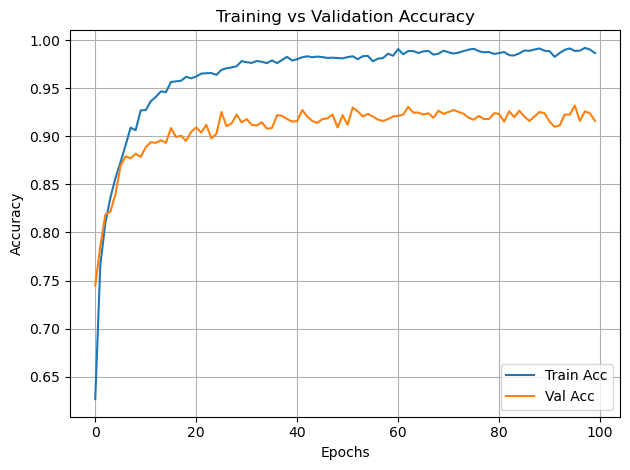

In [ ]:
# 1) Plot loss & accuracy curves
plot_training_history(history)

# 2) Evaluate on test set & plot confusion matrix
cm = evaluate_metrics(model, test_loader, device, class_names)
plot_confusion_matrix(cm, class_names)


In [ ]:
save_path = r"D:\Projects\DL_gtzan\models\Deeper_MLP\deeper_mlp_weights.pth"
torch.save(model.state_dict(), save_path)
